## Recomendación basada en contenidos (Items)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from functools import reduce
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import requests
from bs4 import BeautifulSoup
import random

## Ejercicio

IMDB  permite descargar parte de sus datos desde la siguiente web: https://www.imdb.com/interfaces/

Aqui podemos descargar varios dataset sobre información de los contenidos, nosotros vamos  a usar:

* https://datasets.imdbws.com/title.basics.tsv.gz
* https://datasets.imdbws.com/title.ratings.tsv.gz

Queremos utilizar la información de *keywords* por ejemplo: https://www.imdb.com/title/tt0372784/keywords para montar un sistemas de recomendación basado en esta información.

Por desgracia la información de keywords no se puede descargar de manera masiva para todos... Así que vamos a montar un script para descargar algunos:

In [2]:
imdb_basics = pd.read_csv("../datos/title.basics.tsv.gz", sep="\t")

C:\Users\Javier\AppData\Local\Temp\ipykernel_22272\1391548879.py:1: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  imdb_basics = pd.read_csv("../datos/title.basics.tsv.gz", sep="\t")


In [3]:
imdb_basics.groupby("titleType").tconst.count()

titleType
movie            611473
short            872135
tvEpisode       6732227
tvMiniSeries      43608
tvMovie          136277
tvPilot               2
tvSeries         225843
tvShort           10557
tvSpecial         37155
video            261192
videoGame         31267
Name: tconst, dtype: int64

In [4]:
imdb_basics_pelis = imdb_basics[imdb_basics.titleType == "movie"]

In [5]:
imdb_ratings = pd.read_csv("../datos/title.ratings.tsv.gz", sep="\t")

In [6]:
len(imdb_ratings)

1249576

In [7]:
imdb_ratings = imdb_ratings.merge(imdb_basics_pelis[["tconst"]], on="tconst")

In [8]:
len(imdb_ratings)

278912

In [9]:
imdb_ratings.head()

,tconst,averageRating,numVotes
0,tt0000502,4.5,14
1,tt0000574,6.0,766
2,tt0000591,4.5,18
3,tt0000615,4.5,23
4,tt0000630,3.9,25


In [10]:
imdb_ratings.describe()

,averageRating,numVotes
count,278912.000000,2.789120e+05
mean,6.130985,3.495766e+03
std,1.346696,3.392760e+04
min,1.000000,5.000000e+00
25%,5.300000,1.800000e+01
50%,6.300000,5.800000e+01
75%,7.000000,2.960000e+02
max,10.000000,2.592905e+06


c:\Python310\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='averageRating', ylabel='Density'>

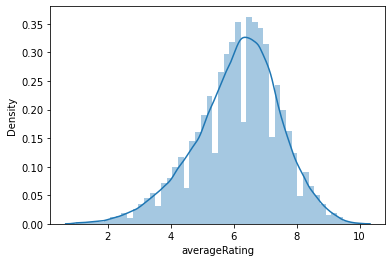

In [11]:
sns.distplot(imdb_ratings["averageRating"])

In [12]:
ids_quiero = imdb_ratings.tconst.values[
    (imdb_ratings.averageRating >= 8) & (imdb_ratings.numVotes >= 770)
]

In [13]:
len(ids_quiero)

1753

In [14]:
def descargar_keywords(x):

    doc = requests.get("https://www.imdb.com/title/{}/keywords".format(x))

    soup = BeautifulSoup(doc.content, "lxml")

    titulo = soup.select_one('meta[name="title"]')["content"].replace(" - IMDb", "")

    keywords = np.array(
        [i.text for i in soup.select("#keywords_content table .sodatext a")]
    )

    return {"idImdb": x, "titulo": titulo, "keywords": keywords}

In [15]:
descargar_keywords(ids_quiero[1000])

{'idImdb': 'tt11023888',
 'titulo': 'Data Science Pioneers: Conquering the Next Frontier (2019)',
 'keywords': array(['data', 'data science', 'big data', 'advanced analytics', 'ai',
        'dataiku', 'pioneers', 'data scientists', 'data leaders', 'ethics'],
       dtype='<U18')}

In [16]:
keywords_df = pd.read_json("../datos/imdb_example_keywords.json")

In [17]:
len(keywords_df)

1502

In [18]:
keywords_df[keywords_df.titulo.str.lower().str.contains("ryan")]

,idImdb,keywords,titulo
761,tt0120815,"[rescue mission, d day, world war two, normand...",Salvar al soldado Ryan (1998)


In [19]:
keywords_df

,idImdb,keywords,titulo
0,tt0006864,"[multiple storyline, babylon babylonia, paris ...",Intolerancia (1916)
1,tt0010323,"[somnambulist, expressionism, hypnosis, avant ...",El gabinete del Dr. Caligari (1920)
2,tt0012349,"[lucifer morningstar character, the little tra...",El chico (1921)
3,tt0012364,"[ghost story, ghost, salvation, alcoholic, tub...",La carreta fantasma (1921)
4,tt0013442,"[vampire, self sacrifice, bite mark, dracula, ...",Nosferatu (1922)
...,...,...,...
1497,tt8760684,"[apollo 11, neil armstrong, buzz aldrin, astro...",Apollo 11 (2019)
1498,tt9124428,"[horse, race, love, success, turkey, hope, can...",Bizim Için Sampiyon (2018)
1499,tt9135854,"[football, barcelona fc, reference to pep guar...","Take the ball, pass the ball (Toca y pasa el b..."
1500,tt9151704,"[korean boy band, pool party, testimonial, con...",Burn The Stage. The movie (2018)


Se pide:
* Repetir el ejercicio hecho pero con el dataset descargado de IMDB
* Jugar con las opciones de `TfidfVectorizer` (por ejemplo `ngram`, `min_df`...) para crear un vocabulario adecuado

El primer paso será convertir la lista de keywords que tenemos en un string único con todos los elementos.

In [20]:
keywords_df['keywords_str'] = keywords_df.keywords.apply(lambda keywords: ' '.join(keywords))
keywords_df

,idImdb,keywords,titulo,keywords_str
0,tt0006864,"[multiple storyline, babylon babylonia, paris ...",Intolerancia (1916),multiple storyline babylon babylonia paris fra...
1,tt0010323,"[somnambulist, expressionism, hypnosis, avant ...",El gabinete del Dr. Caligari (1920),somnambulist expressionism hypnosis avant gard...
2,tt0012349,"[lucifer morningstar character, the little tra...",El chico (1921),lucifer morningstar character the little tramp...
3,tt0012364,"[ghost story, ghost, salvation, alcoholic, tub...",La carreta fantasma (1921),ghost story ghost salvation alcoholic tubercul...
4,tt0013442,"[vampire, self sacrifice, bite mark, dracula, ...",Nosferatu (1922),vampire self sacrifice bite mark dracula gothi...
...,...,...,...,...
1497,tt8760684,"[apollo 11, neil armstrong, buzz aldrin, astro...",Apollo 11 (2019),apollo 11 neil armstrong buzz aldrin astronaut...
1498,tt9124428,"[horse, race, love, success, turkey, hope, can...",Bizim Için Sampiyon (2018),horse race love success turkey hope cancer
1499,tt9135854,"[football, barcelona fc, reference to pep guar...","Take the ball, pass the ball (Toca y pasa el b...",football barcelona fc reference to pep guardio...
1500,tt9151704,"[korean boy band, pool party, testimonial, con...",Burn The Stage. The movie (2018),korean boy band pool party testimonial concert...


Probamos a crear distintos vocabularios utilizando diferentes parámetros de TfidfVectorizer para después comparar.

En la primera ejecución usaremos los parámetros por defecto, a destacar: min_df=1, ngram_range=(1, 1)

In [21]:
tf = TfidfVectorizer(analyzer="word").fit(keywords_df.keywords_str)

Vemos ejemplos de su vocabulario:

In [22]:
tf.vocabulary_

{'multiple': 9824,
 'storyline': 14181,
 'babylon': 1253,
 'babylonia': 1254,
 'paris': 10716,
 'france': 5943,
 'jerusalem': 7923,
 'time': 14965,
 'frames': 5940,
 'national': 9945,
 'film': 5629,
 'registry': 12104,
 'deception': 4045,
 'intolerance': 7746,
 'huguenot': 7265,
 'medicis': 9277,
 'wedding': 16070,
 'protestant': 11642,
 'mill': 9453,
 'marriage': 9100,
 'judea': 8017,
 'reformer': 12079,
 'massacre': 9156,
 'epic': 5143,
 'saved': 12783,
 'from': 6024,
 'hanging': 6751,
 'naivety': 9905,
 'hypocrisy': 7351,
 '6th': 284,
 'century': 2711,
 '16th': 42,
 'actor': 416,
 'playing': 11207,
 'roles': 12469,
 'usurper': 15623,
 'trial': 15247,
 'treachery': 15218,
 'sword': 14530,
 'fight': 5612,
 'suicide': 14350,
 'spinster': 13870,
 'self': 13037,
 'sacrifice': 12634,
 'royalty': 12552,
 'robbery': 12433,
 'remorse': 12158,
 'religious': 12137,
 'persecution': 10934,
 'rehabilitation': 12109,
 'priest': 11509,
 'prayer': 11435,
 'police': 11280,
 'murder': 9836,
 'miracle'

Más ejemplos aleatorios:

In [23]:
dict([random.choice(list(tf.vocabulary_.items())) for i in range(10)])


{'1910s': 90,
 'lib': 8541,
 'price': 11505,
 'destroys': 4249,
 'crypto': 3826,
 'stomped': 14150,
 'jakarta': 7867,
 'battleground': 1493,
 'relay': 12128,
 'lovegood': 8765}

Probamos ahora a modificar el parámetro de ngram_range con valor (1,2), lo que nos permitirá añadir al vocabulario bigramas.

In [24]:
tf2 = TfidfVectorizer(analyzer="word", ngram_range=(1,2)).fit(keywords_df.keywords_str)

In [25]:
tf2.vocabulary_

{'multiple': 91910,
 'storyline': 134247,
 'babylon': 10437,
 'babylonia': 10439,
 'paris': 100813,
 'france': 56954,
 'jerusalem': 75830,
 'time': 141714,
 'frames': 56942,
 'national': 93587,
 'film': 53212,
 'registry': 113448,
 'deception': 38983,
 'intolerance': 74089,
 'huguenot': 69819,
 'medicis': 87329,
 'wedding': 153768,
 'protestant': 109818,
 'mill': 88736,
 'marriage': 85935,
 'judea': 76591,
 'reformer': 113333,
 'massacre': 86575,
 'epic': 47648,
 'saved': 120819,
 'from': 58046,
 'hanging': 64949,
 'naivety': 93183,
 'hypocrisy': 70559,
 '6th': 1434,
 'century': 25018,
 '16th': 115,
 'actor': 2551,
 'playing': 105116,
 'roles': 118406,
 'usurper': 149480,
 'trial': 146346,
 'treachery': 146069,
 'sword': 137163,
 'fight': 52749,
 'suicide': 135417,
 'spinster': 131603,
 'self': 123153,
 'sacrifice': 119850,
 'royalty': 119198,
 'robbery': 117970,
 'remorse': 115325,
 'religious': 115182,
 'persecution': 102556,
 'rehabilitation': 113571,
 'priest': 108060,
 'prayer': 1

In [26]:
[random.choice(list(tf2.vocabulary_.items())) for i in range(10)]

[('communist epic', 31562),
 ('insecurity outcast', 73232),
 ('robe revolver', 118095),
 ('piano family', 103727),
 ('column 21', 30823),
 ('hospital ward', 69246),
 ('blockbuster revolving', 15690),
 ('activity illegal', 2546),
 ('accident attempted', 2060),
 ('business jet', 20723)]

Por último, vamos a cambiar el parámetro min_df que se relaciona con la frecuencia mínima con la que tiene que aparecer un término.

In [27]:
tf3 = TfidfVectorizer(analyzer="word", min_df = 0.005).fit(keywords_df.keywords_str)

In [28]:
tf3.vocabulary_

{'multiple': 2238,
 'storyline': 3253,
 'paris': 2428,
 'france': 1400,
 'time': 3453,
 'national': 2270,
 'film': 1315,
 'registry': 2753,
 'deception': 946,
 'intolerance': 1801,
 'wedding': 3718,
 'mill': 2161,
 'marriage': 2090,
 'massacre': 2103,
 'epic': 1187,
 'saved': 2916,
 'from': 1416,
 'hanging': 1572,
 'naivety': 2260,
 'hypocrisy': 1706,
 'century': 615,
 '16th': 3,
 'actor': 60,
 'playing': 2540,
 'roles': 2850,
 'trial': 3527,
 'treachery': 3521,
 'sword': 3338,
 'fight': 1307,
 'suicide': 3293,
 'spinster': 3174,
 'self': 2969,
 'sacrifice': 2888,
 'royalty': 2874,
 'robbery': 2839,
 'remorse': 2771,
 'religious': 2766,
 'persecution': 2477,
 'rehabilitation': 2755,
 'priest': 2611,
 'prayer': 2589,
 'police': 2556,
 'murder': 2240,
 'miracle': 2170,
 'military': 2159,
 'invasion': 1804,
 'proposal': 2643,
 'machine': 2044,
 'gun': 1540,
 'kiss': 1900,
 'justice': 1877,
 'jew': 1850,
 'injustice': 1772,
 'infidelity': 1763,
 'hypocrite': 1707,
 'governor': 1499,
 'goat

In [29]:
[random.choice(list(tf3.vocabulary_.items())) for i in range(10)]

[('chopping', 669),
 ('garbage', 1445),
 ('drama', 1072),
 ('blind', 393),
 ('publisher', 2666),
 ('cash', 588),
 ('impostor', 1746),
 ('gunfire', 1543),
 ('murderer', 2242),
 ('decoy', 948)]

A continuación, creamos las matrices  que necesitamos para aplicar sobre ellas cálculos de similitud.

In [30]:
tfidf_matrix = tf.transform(keywords_df.keywords_str)
tfidf_matrix_2 = tf2.transform(keywords_df.keywords_str)
tfidf_matrix_3 = tf3.transform(keywords_df.keywords_str)

In [31]:
tfidf_matrix

<1502x16491 sparse matrix of type '<class 'numpy.float64'>'
	with 167863 stored elements in Compressed Sparse Row format>

In [32]:
tfidf_matrix_2

<1502x158325 sparse matrix of type '<class 'numpy.float64'>'
	with 385750 stored elements in Compressed Sparse Row format>

In [33]:
tfidf_matrix_3

<1502x3817 sparse matrix of type '<class 'numpy.float64'>'
	with 140331 stored elements in Compressed Sparse Row format>

In [34]:
print(f"shape tfidf_matrix: {tfidf_matrix.shape}")
print(f"shape tfidf_matrix_2: {tfidf_matrix_2.shape}")
print(f"shape tfidf_matrix_3: {tfidf_matrix_3.shape}")

shape tfidf_matrix: (1502, 16491)
shape tfidf_matrix_2: (1502, 158325)
shape tfidf_matrix_3: (1502, 3817)


Calculamos las distancias coseno para cada matriz para utilizarlas como medida de similitud.

In [35]:
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)
cosine_sim_2 = cosine_similarity(tfidf_matrix_2, tfidf_matrix_2)
cosine_sim_3 = cosine_similarity(tfidf_matrix_3, tfidf_matrix_3)

Creamos una función que reciba el título de una de nuestras películas y una de las matrices de similitud que hemos creado. Esta función nos devuelve las 6 películas con más similitud con la introducida en base a la matriz de similitud elegida.

In [36]:
titles = keywords_df["titulo"]
indices = pd.Series(keywords_df.index, index=keywords_df["titulo"])

def keywords_recommendations(title, cosine_sim):
    idx = indices[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:7]
    movie_indices = [i[0] for i in sim_scores]
    return titles.iloc[movie_indices]

Probamos las distintas recomendaciones para cada método que hemos creado con algunas películas:

In [37]:
def film_recommendation(pelicula):
  print(f"cosine_sim:\n{keywords_recommendations(pelicula, cosine_sim)}")
  print(f"\ncosine_sim_2:\n{keywords_recommendations(pelicula, cosine_sim_2)}")
  print(f"\ncosine_sim_3:\n{keywords_recommendations(pelicula, cosine_sim_3)}")
  return

In [38]:
film_recommendation('Batman Begins (2005)')

cosine_sim:
1191    El caballero oscuro: La leyenda renace (2012)
1081                       El caballero oscuro (2008)
1365                                     Logan (2017)
1300                                The Raid 2 (2014)
1196                                    Origen (2010)
1401                  Vengadores: Infinity War (2018)
Name: titulo, dtype: object

cosine_sim_2:
1191    El caballero oscuro: La leyenda renace (2012)
1081                       El caballero oscuro (2008)
1365                                     Logan (2017)
1300                                The Raid 2 (2014)
1401                  Vengadores: Infinity War (2018)
1203                                  Deadpool (2016)
Name: titulo, dtype: object

cosine_sim_3:
1191    El caballero oscuro: La leyenda renace (2012)
1081                       El caballero oscuro (2008)
1365                                     Logan (2017)
1401                  Vengadores: Infinity War (2018)
1048                               Inf

In [39]:
film_recommendation('El padrino (1972)')

cosine_sim:
437      El padrino: Parte II (1974)
652       Uno de los nuestros (1990)
1300               The Raid 2 (2014)
703     El profesional (Léon) (1994)
617                   Nayakan (1987)
1048              Infiltrados (2006)
Name: titulo, dtype: object

cosine_sim_2:
1300                     The Raid 2 (2014)
437            El padrino: Parte II (1974)
652             Uno de los nuestros (1990)
703           El profesional (Léon) (1994)
1365                          Logan (2017)
1044    Sin City: Ciudad del pecado (2005)
Name: titulo, dtype: object

cosine_sim_3:
652       Uno de los nuestros (1990)
437      El padrino: Parte II (1974)
703     El profesional (Léon) (1994)
1300               The Raid 2 (2014)
1048              Infiltrados (2006)
568       El precio del poder (1983)
Name: titulo, dtype: object


In [40]:
film_recommendation('Ciudadano Kane (1941)')

cosine_sim:
121                                 Eva al desnudo (1950)
1140                        El lobo de Wall Street (2013)
1374                                   Sing Street (2016)
1402    Going Clear: Scientology & the Prison of Belie...
1332                                        Wonder (2017)
1387       La ciudad de las estrellas (La La Land) (2016)
Name: titulo, dtype: object

cosine_sim_2:
121                                 Eva al desnudo (1950)
1374                                   Sing Street (2016)
1402    Going Clear: Scientology & the Prison of Belie...
1332                                        Wonder (2017)
1140                        El lobo de Wall Street (2013)
1387       La ciudad de las estrellas (La La Land) (2016)
Name: titulo, dtype: object

cosine_sim_3:
121                                 Eva al desnudo (1950)
1140                        El lobo de Wall Street (2013)
1374                                   Sing Street (2016)
1402    Going Clear: Scientology

Como podemos ver, las diferentes implementaciones nos devuelven resultados bastante similares aún viendo la diferencia de tamaño entre las matrices.